In [1]:
import tensorflow as tf
from utils import get_input_shapes, generate_syntetic_data
from preprocessing import Preprocessor
from models import AdditiveDecomposition, TrueSight
from metrics import Evaluator, smape, mape, mse, rmse, mae
from statsforecast.models import AutoARIMA, SeasonalNaive

In [2]:
num_time_steps = 60
seasonal_lenght = 12
forecast_horizon = 12
df = generate_syntetic_data(num_time_steps, seasonal_lenght, 10000)

In [3]:
preprocessor = Preprocessor(df)
X_train, Y_train, ids_train, X_val, Y_val, ids_val, models = preprocessor.make_dataset(
    forecast_horizon = 12, 
    season_length = 12,
    date_freq = "MS", 
    models = [AdditiveDecomposition, AutoARIMA, SeasonalNaive], 
    fallback_model = SeasonalNaive,
    verbose = True
    )

In [ ]:
input_shapes = get_input_shapes(X_train)
truesight = TrueSight(models, input_shapes, forecast_horizon = forecast_horizon)
truesight.auto_tune(X_train, Y_train, X_val, Y_val, n_trials = 50, batch_size = 512, epochs = 5)

[I 2023-05-19 10:05:48,385] A new study created in memory with name: no-name-31e618b4-08c8-4402-8b27-953302775da5
[I 2023-05-19 10:06:03,439] Trial 0 finished with value: 911.0888671875 and parameters: {'num_filters': 256, 'kernel_size': 5, 'lstm_units': 175, 'hidden_size': 457, 'num_heads': 7, 'key_dim': 25, 'dropout_rate': 0.22987152153266766, 'learning_rate': 0.0035625516957706166}. Best is trial 0 with value: 911.0888671875.
[I 2023-05-19 10:06:19,226] Trial 1 finished with value: 9215.0390625 and parameters: {'num_filters': 89, 'kernel_size': 8, 'lstm_units': 164, 'hidden_size': 923, 'num_heads': 9, 'key_dim': 104, 'dropout_rate': 0.11980056885810149, 'learning_rate': 0.0070299567615107255}. Best is trial 0 with value: 911.0888671875.
[I 2023-05-19 10:06:33,829] Trial 2 finished with value: 879.9263916015625 and parameters: {'num_filters': 225, 'kernel_size': 6, 'lstm_units': 157, 'hidden_size': 213, 'num_heads': 10, 'key_dim': 128, 'dropout_rate': 0.09326032539487944, 'learning_r

[I 2023-05-19 10:07:04,328] Trial 4 finished with value: 895.3004150390625 and parameters: {'num_filters': 140, 'kernel_size': 17, 'lstm_units': 74, 'hidden_size': 153, 'num_heads': 2, 'key_dim': 101, 'dropout_rate': 0.26841593114941864, 'learning_rate': 0.007041654532174878}. Best is trial 2 with value: 879.9263916015625.


[I 2023-05-19 10:07:22,468] Trial 5 finished with value: 1117.492919921875 and parameters: {'num_filters': 159, 'kernel_size': 12, 'lstm_units': 153, 'hidden_size': 640, 'num_heads': 5, 'key_dim': 98, 'dropout_rate': 0.13764613822861593, 'learning_rate': 0.00596764106602947}. Best is trial 2 with value: 879.9263916015625.
[I 2023-05-19 10:07:39,136] Trial 6 finished with value: 1103.661376953125 and parameters: {'num_filters': 57, 'kernel_size': 8, 'lstm_units': 226, 'hidden_size': 1001, 'num_heads': 10, 'key_dim': 60, 'dropout_rate': 0.3381219483233819, 'learning_rate': 0.005488292315624502}. Best is trial 2 with value: 879.9263916015625.
[I 2023-05-19 10:07:59,987] Trial 7 finished with value: 1013.3499755859375 and parameters: {'num_filters': 149, 'kernel_size': 16, 'lstm_units': 121, 'hidden_size': 897, 'num_heads': 10, 'key_dim': 69, 'dropout_rate': 0.1276741048233535, 'learning_rate': 0.0026821634148474958}. Best is trial 2 with value: 879.9263916015625.
[I 2023-05-19 10:08:17,26

{'num_filters': 225,
 'kernel_size': 6,
 'lstm_units': 157,
 'hidden_size': 213,
 'num_heads': 10,
 'key_dim': 128,
 'dropout_rate': 0.09326032539487944,
 'learning_rate': 0.0005684692761643893}


Epoch 130: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 166: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 209: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 234: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 279: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 304: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 329: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 354: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


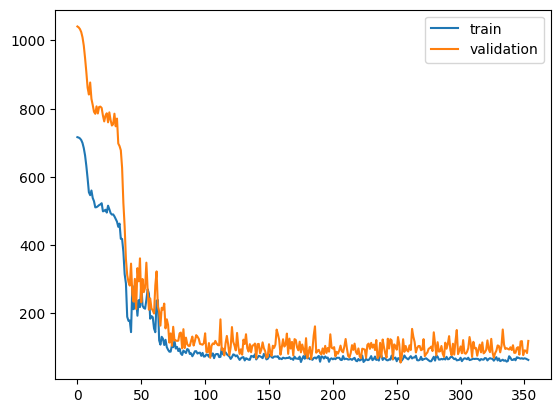

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 100, restore_best_weights = True, monitor = "val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 25, verbose = 1),
]
truesight.fit(X_train, Y_train, X_val, Y_val, batch_size = 128, epochs = 1000, verbose = False, callbacks = callbacks)
truesight.plot_history()

In [ ]:
Y_hat = truesight.predict(X_val, batch_size = 500, n_repeats = 100, n_quantiles = 15, return_quantiles = True, verbose = False)

In [ ]:
evaluator = Evaluator(X_val, Y_val, Y_hat, ids_val)
evaluator.evaluate_prediction([smape, mape, mse, rmse, mae], return_mean=True)

smape     0.690499
mape      0.764153
mse      82.292912
rmse      7.026204
mae       5.946820
dtype: float64

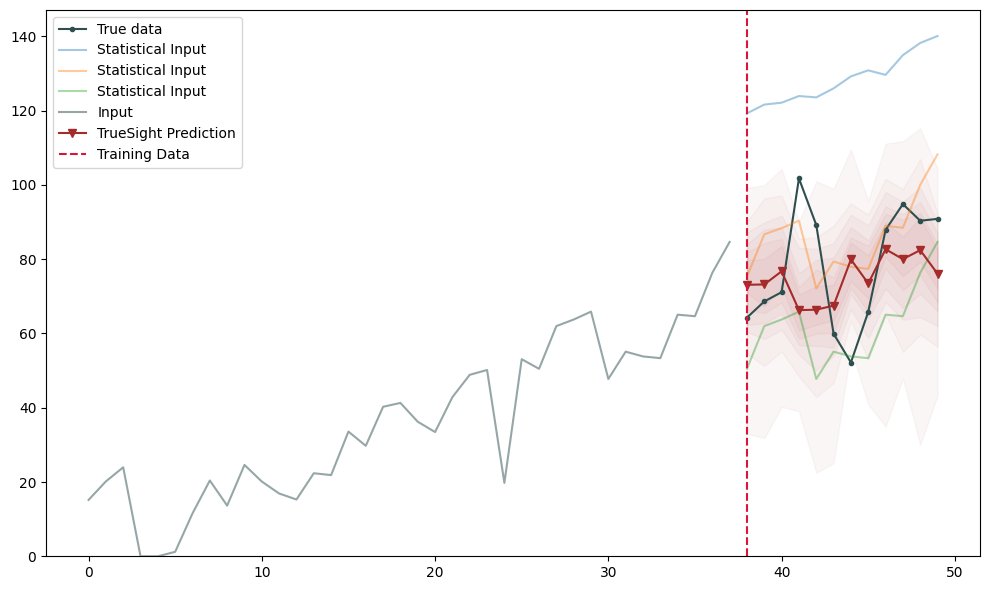

In [ ]:
evaluator.plot_exemple()